In [1]:
# Import pymsg

import sys
import os
sys.path.insert(0, os.path.join(os.environ['MSG_DIR'], 'lib'))
import pymsg

# Import standard modules and configure them

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams.update({'font.size': 16})

In [2]:
import h5py
from scipy.integrate import quad as integrate
from scipy.special import lpmv, sph_harm
from scipy.optimize import fsolve

import f90nml as nml
from shutil import copyfile

#from PyAstronomy import pyasl
from astropy.io import ascii
#import ipywidgets as ipw

In [3]:
# must have atm_coeffs.py and resp_coeffs.py 
# in notebook directory

import atm_coeffs as ac
import resp_coeffs as rc
from star_class import Star
from irrad_class import Irradiation

In [9]:
class Binary(Irradiation):
    
    def __init__ (self, inlist_path):
        
        # should check if 'inlist', this just checks 'str'
        
        if isinstance(inlist_path, str):
            self.nml = nml.read(inlist_path)
        else: raise Exception('Inlist file error')
        
        self.orbit_params = self.read_orbit()
        
        self.component = {1: Star(inlist_path, 1),\
                          2: Star(inlist_path, 2) }
        
        super().__init__()
        
    def read_orbit(self):
        
        orbit_inlist = self.nml['orbit']
        
        params = {}
        
        #placeholder unit routine
        
        if orbit_inlist['omega_orb_units']=='CYC_PER_DAY':
            omega_orb_units = 1 
        else: omega_orb_units = 1
        
        if orbit_inlist['a_units']=='CM':
            a_units = 6.957e10 #cm per r_sol
        else: a_units = 1
            
        # eventually, we want to get these from resp_data
        # resp_data currently does not contain this output tho
        
        params['a'] = orbit_inlist['a']*a_units
        params['e'] = orbit_inlist['e']
        params['Omega_orb'] = orbit_inlist['omega_orb']*omega_orb_units
        
        return params
    
    '''
    def eval_fourier (self, filter_x, inc, omega, t=0, reflection=True):
        
        omega_orb = self.orbit_params['Omega_orb']
        
        f_1, A_1 = self.component[1].eval_fourier(filter_x, inc, omega)
        f_2, A_2 = self.component[2].eval_fourier(filter_x, inc, omega+180)
        
        if reflection==True:
            
            rf_1, rA_1 = self.system.eval_fourier_irrad(1, self.filter_x, inc, omega, t, t_peri)
            rf_2, rA_2 = self.system.eval_fourier_irrad(2, self.filter_x, inc, omega+180, t, t_peri)
            
            return [f_1/omega_orb, rf_1, f_2/omega_orb, rf_2], [A_1, rA_1, A_2, rA_2]
        
        else:
            return [f_1/omega_orb, f_2/omega_orb], [A_1, A_2]
    '''

In [10]:
class Observer:
    
    def __init__ (self, star_system, filter_x, use_msg=True, phot_file=None):
        
        self.filter_x = filter_x
        self.use_msg = use_msg
        self.system = star_system
        
        if isinstance(star_system, Binary):
            
            self.system_type = 'binary'
            if use_msg==True:
                self.system.component[1].read_phot_coeffs(self.filter_x)
                self.system.component[2].read_phot_coeffs(self.filter_x)
            else:
                self.system.component[1].read_phot_coeffs(self.filter_x, 1)
                self.system.component[2].read_phot_coeffs(self.filter_x, 2)
                
        elif isinstance(star_system, Star):
            
            self.system_type = 'single'
            if use_msg==True:
                self.system.read_phot_coeffs(self.filter_x)
                
        else: raise Exception(f'Input error: {star_system} must be of class Binary() or Star()')
        
        
    
    def convert_coords (self, inc, omega):

        theta = inc/180 * np.pi
        phi = (90-omega)/180 * np.pi
        
        return theta, phi
    
    
    def eval_flux_single (self, star, inc, omega, t, t_peri=0):
        
        theta, phi = self.convert_coords(inc, omega)
        f, A = star.eval_fourier(self.filter_x, theta, phi)
        
        # Initialize the frequencies/amplitudes arrays
        
        if isinstance(t, np.ndarray):
            star_flux = np.zeros_like(t)
        elif isinstance(t, list):
            t = np.array(t)
            star_flux = np.zeros_like(t)
        else: #How to isinstance any mathable t? float, int, etc?
            star_flux = 0.

        # Add contributions from each frequency component

        star_dict = {}

        for k in range(len(A)):
            
            star_flux += np.real(A[k] * np.exp(-1j*f[k]*2*np.pi*(t - t_peri)))
            #star_dict[k] = np.real(A[k] * np.exp(-1j*f[k]*2*np.pi*(t - t_peri)))
            
        return star_flux#, star_dict
    
    
    def eval_flux_binary (self, inc, omega, t, t_peri=0, reflection=True):
        
        resp_1 = self.eval_flux_single(self.system.component[1], inc, omega, t, t_peri)
        resp_2 = self.eval_flux_single(self.system.component[2], inc, omega+180, t, t_peri)
        
        L1 = self.system.component[1].params['L']
        L2 = self.system.component[2].params['L']
        
        if reflection==True:
            
            refl_1 = self.system.find_irrad(1, self.filter_x, inc, omega, t, t_peri)
            refl_2 = self.system.find_irrad(2, self.filter_x, inc, omega+180, t, t_peri)
            
            flux = L1*(refl_1 + resp_1) + L2*(refl_2 + resp_2)
        
        else:
            flux = L1*resp_1 + L2*resp_2
            
        return flux/(L1+L2)
    
    
    def find_flux (self, inc, omega, t, t_peri=0, reflection=True):
        
        if self.system_type=='binary':
            return self.eval_flux_binary(inc, omega, t, t_peri, reflection)
        elif self.system_type=='single':
            return self.eval_flux_single(self.system, inc, omega, t, t_peri)
        
    '''
    def find_fourier (self, inc, omega, t=0, reflection=True):
        
        if self.system_type=='binary':
            return self.system.eval_fourier(self.filter_x, inc, omega, t, reflection)
        if self.system_type=='single':
            return self.system.eval_fourier(self.filter_x, inc, omega)
    '''

In [12]:
# Evaluate fourier terms
inc = 62.86
omega = 122.2

iori = Binary('bin_params.in')

obs1 = Observer(iori, 'BRITE-B')
obs2 = Observer(iori, 'BRITE-R')

omega_orb = iori.orbit_params['Omega_orb']
t = np.linspace(0.5/omega_orb, 2.5/omega_orb, num=2000, endpoint=False)

flux_1 = obs1.find_flux(inc, omega, t, reflection=False)

In [7]:
z = [np.max(np.abs(vals)) for vals in a1.values()]
y = list(a1.keys())
max_moments = sorted(zip(z, y), reverse=True)[:3]

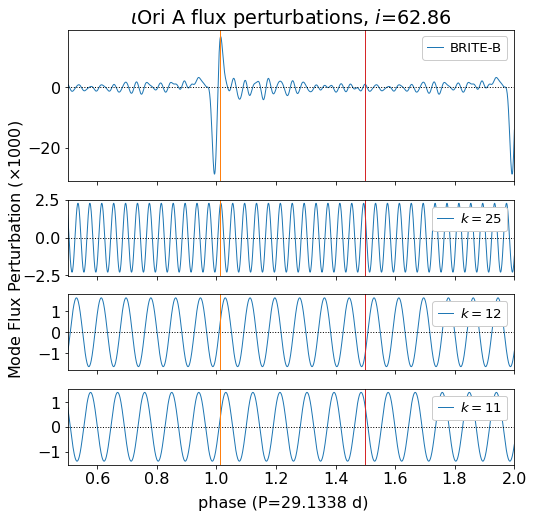

In [8]:
# Plot
grid_style={'height_ratios': [2, 1, 1, 1]}
fig, ax = plt.subplots(4,1, sharex=True, figsize=(8,8), gridspec_kw=grid_style)

legend_style = {'framealpha':1.0, 'handlelength':1.2, 'handletextpad':0.5, 'fontsize':'small'}

ax[0].plot(t*omega_orb, (flux_1)*1000, lw=1, label='BRITE-B')
ax[0].legend(loc=1, **legend_style)

ax[0].axhline(y=0, xmin=0, xmax=1, lw=1, ls=':', color='k')
ax[0].axvline(x=1.013, ymin=0, ymax=1, lw=1, color='C1')
ax[0].axvline(x=1.5, ymin=0, ymax=1, lw=1, color='C3')

for i, item in enumerate(max_moments):
    ax[i+1].plot(t*omega_orb, (a1[item[1]] )*1000, lw=1, label=r'$k=$'+f'{item[1]}')
    ax[i+1].legend(loc=1, **legend_style)
    
    ax[i+1].axhline(y=0, xmin=0, xmax=1, lw=1, ls=':', color='k')
    ax[i+1].axvline(x=1.013, ymin=0, ymax=1, lw=1, color='C1')
    ax[i+1].axvline(x=1.5, ymin=0, ymax=1, lw=1, color='C3')
    
ax[0].set_xlim(0.5,2.)
#ax.set_ylim(0.95*1000,1.15*1000)

ax[0].set_title(f'$\iota$Ori A flux perturbations, $i$={inc}')

fig.text(0.02, 0.5, r'Mode Flux Perturbation ($\times 1000$)', va='center', rotation='vertical')
fig.text(0.5, 0.05, f"phase (P={1./omega_orb:4.4f} d)", ha='center')

#fig.savefig('mode-interference.png')

In [275]:
def eval_fourier_irrad (observer, inc, omega, t, t_peri=0):
    
    # Begin time period of the signals
    beginTime = t[0]
    # End time period of the signals
    endTime = t[-1] 
    
    # Orbital frequency
    omega_orb = observer.system.orbit_params['Omega_orb']
    
    # Signal
    signal_1 = observer.system.find_irrad(1, 'BRITE-B', inc, omega, t, t_peri)
    signal_2 = observer.system.find_irrad(2, 'BRITE-B', inc, omega+180, t, t_peri)
    #signal = signal_1 + signal_2
    signal = observer.find_flux(inc, omega, t) - signal_1 - signal_2
    
    #How many time points are needed i,e., Sampling Frequency
    samplingFrequency = t.size #endTime - beginTime)
    
    # Frequency of the signals
    signalFrequency = np.fft.rfftfreq(signal.size, 1/samplingFrequency)
    signalFrequency = signalFrequency[range(int(len(signal)/2))]
    
    # Frequency domain representation
    fourierTransform = np.fft.fft(signal)/len(signal) # Normalize amplitude
    fourierTransform = fourierTransform[range(int(len(signal)/2))] # Exclude sampling frequency
    
    return signalFrequency, fourierTransform

In [276]:
freq, fourier = eval_fourier_irrad(obs1, inc, omega, t)

In [277]:
freqs, fouriers = obs1.find_fourier(inc, omega, t, reflection=False)

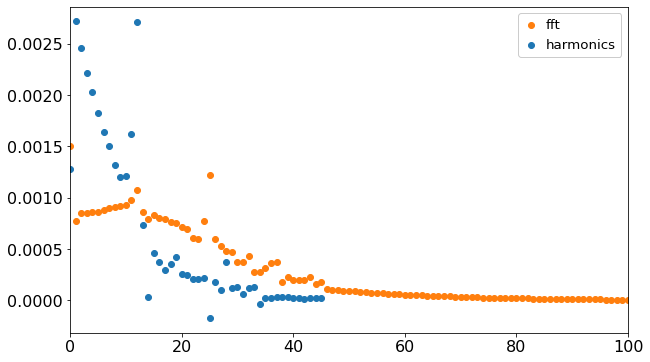

In [281]:
# Plot
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,6))

ax.scatter(freq, np.abs(fourier), label='fft', c='C1')
ax.scatter(freqs[0], fouriers[0]+fouriers[1],label='harmonics')



ax.set_xlim(0,100)
#ax.set_ylim(0.95*1000,1.15*1000)

legend_style = {'framealpha':1.0, 'handlelength':1.2, 'handletextpad':0.5, 'fontsize':'small'}
ax.legend(loc=1, **legend_style)

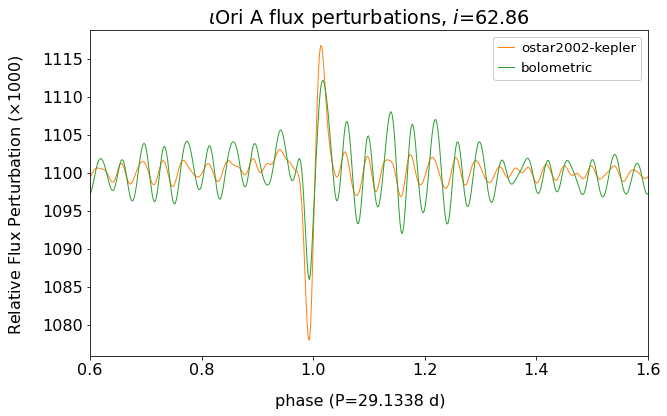

In [27]:
# Evaluate fourier terms
inc = 62.86
omega = 122.2

iori = Binary('bin_params.in')

obs1 = Observer(iori, 'ostar2002-kepler')
obs2 = Observer(iori, 'bol', use_msg=False, phot_file=1)

omega_orb = iori.orbit_params['Omega_orb']
t = np.linspace(-1.5/omega_orb, 2.5/omega_orb, 2000)

flux_1 = obs1.find_flux(inc, omega, t)
flux_2 = obs2.find_flux(inc, omega, t)

#---------------------------------------

# Plot
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,6))

ax.plot(t*omega_orb, (flux_1 + 1.1)*1000, c='C1', lw=1, label='ostar2002-kepler')
ax.plot(t*omega_orb, (flux_2 + 1.1)*1000, c='C2', lw=1, label='bolometric')

ax.set_xlim(0.6,1.6)
#ax.set_ylim(0.95*1000,1.15*1000)

legend_style = {'framealpha':1.0, 'handlelength':1.2, 'handletextpad':0.5, 'fontsize':'small'}
ax.legend(loc=1, **legend_style)

ax.set_title(f'$\iota$Ori A flux perturbations, $i$={inc}')

fig.text(0.01, 0.5, r'Relative Flux Perturbation ($\times 1000$)', va='center', rotation='vertical')
fig.text(0.5, 0.01, f"phase (P={1./omega_orb:4.4f} d)", ha='center')

fig.savefig(f'iOri_response_msg-bol.png')

Put together a description of the code for Rich. What it is, what it does. Some examples of its use for certain systems. Examples of questions I anticipate Rich will have. 

Imagine that Rich reads through my description. What will Rich not understand? What will I assume Rich knows, but he might not?

J: If you find yourself not knowing how to anticipate questions, just send it to Rich. Give yourself time to percolate, but then do send to Rich.

R: You'll find that writing about the code will actually change the code. Also, don't go into the user inputs in the paper-- that's what a user manual is for. What the GYRE paper does, is it talks about the principles and nuerical methods that the user must understand in order to fully appreciate the code. The instrument paper says nothing about how to install, how to change params, etc. "These are the fundamentals of how the code works, here's what it does, and here's some example use cases."

In [609]:
class Star:
    """Takes path to inlist specifying stellar parameters 
    necessary for plotting a light curve.
    
    Arguments
    ---------
    inlist_path : str
    star_number : int
    
    Attributes
    ----------
    self.inlist_path : str
    self.params : dict
    self.resp_coeffs : dict
    
    Methods
    -------
    +read_mesa_params(star_model_path) : dict
    +read_phot_coeffs_h5(filter_x, phot_file) : dict
    +read_phot_coeffs_msg(filter_x) : dict
    +read_phot_coeffs(filter_x, phot_file) : dict
    +D_moment(l, filter_x, deriv) : float
    +R_xl(filter_x, l) : float
    +T_xl(filter_x, l) : float
    +G_xl(filter_x, l) : float
    +disk_intg_factor(filter_x, l) : float
    +eval_fourier_moment(filter_x, theta, phi, l,m,k) : float
    +eval_fourier(filter_x, inc, omega, bol) : [array, array]
    """
    
    def __init__ (self, inlist_path, star_number=1):
        
        # should check if 'inlist', this just checks 'str'
        
        if isinstance(inlist_path, str):
            self.inlist_path = inlist_path
            star_inlist = nml.read(inlist_path)[f'star_{star_number}']
            #observer_inlist = nml.read(inlist_path)[f'observer']
        else: raise Exception('Inlist file error')
        
        self.params = self.read_mesa_params(star_inlist['star_model_path'])
        
        self.resp_coeffs = rc.resp_coeffs(star_inlist['tide_model_path'])
        
        self.phot_coeffs = {}
        
            
    def read_mesa_params(self, star_model_path, units='SOLAR'):
        
        data = ascii.read(star_model_path, data_start=0, data_end=1)
        
        # cgs constants
        
        R_sol = 6.957e10 
        M_sol = 1.989e33
        L_sol = 3.839e33
        G = 6.674079999999999e-08 
        sigma_sb = 5.6703669999999995e-05
        
        # data in cgs
        
        m = data[0][1]
        r = data[0][2]
        l = data[0][3]
            
        # calculate Teff [K], logg [dex]
        
        Teff = (l/(sigma_sb * 4*np.pi*r**2))**0.25
        
        g_surf = G*m/(r**2)
        
        logg = np.log10(g_surf)
        
        # convert to solar units
        
        if units=='SOLAR':
            m = m/M_sol
            r = r/R_sol
            l = l/L_sol
            
        return {'M': m,
                'R': r,
                'L': l,
                'Teff': Teff,
                'logg': logg}

    
    
    def read_phot_coeffs_h5(self, filter_x, phot_file):
        """
        This function is old and uses a synspec
        intensity spectrum calculated from iOri's 
        tlusty atmosphere.
        """
        
        l_min = 0
        dl = 1
        l_max = self.resp_coeffs.data['l_max']
        n_l = np.ceil( (l_max - l_min)/dl ) + 1

        l_range = l_min + dl*np.arange(n_l)
        
        # read intensity file
        
        I = ac.atm_coeffs(phot_file)
        I = I.data
        
        # Evaluate photometric data
        I_x_l = {}
        dI_dlnT_x_l = {}
        dI_dlng_x_l = {}
        
        for l in l_range.astype(int):
            I_x_l[l] = I[f'I_{filter_x}_{l}'][0]
            dI_dlnT_x_l[l] = I[f'dlnTeff_{filter_x}_{l}'][0]
            dI_dlng_x_l[l] = I[f'dlng_{filter_x}_{l}'][0]
            
        return {f'I_{filter_x}': I_x_l,
                f'dI_dlnT_{filter_x}': dI_dlnT_x_l,
                f'dI_dlng_{filter_x}': dI_dlng_x_l}

    
    def read_phot_coeffs_msg(self, filter_x): 
        
        # Set atmosphere parameters dict
    
        Teff = self.params['Teff']
        logg = self.params['logg']

        dx = {'logT': np.log10(Teff), 'logg': logg}
        pg = pymsg.PhotGrid(f'pg-demo-{filter_x}.h5')
        
        # Set up intensity moment range
        
        l_min = 0
        dl = 1
        l_max = self.resp_coeffs.data['l_max']
        n_l = np.ceil( (l_max - l_min)/dl ) + 1

        l_range = l_min + dl*np.arange(n_l)
        
        # Evaluate photometric data
        I_x_l = {}
        dI_dlnT_x_l = {}
        dI_dlng_x_l = {}
        
        for l in l_range.astype(int):
            I_x_l[l] = pg.D_moment(dx, l)
            dI_dlnT_x_l[l] = pg.D_moment(dx, l, deriv={'logT':True})/np.log(10.)
            dI_dlng_x_l[l] = pg.D_moment(dx, l, deriv={'logg':True})/np.log(10.)
            
        return {f'I_{filter_x}': I_x_l, 
                f'dI_dlnT_{filter_x}': dI_dlnT_x_l, 
                f'dI_dlng_{filter_x}': dI_dlng_x_l}
    
    
    def read_phot_coeffs(self, filter_x, phot_file=None):
        
        if phot_file==None:
            self.phot_coeffs.update( self.read_phot_coeffs_msg(filter_x) )
        elif phot_file==1:
            self.phot_coeffs.update( self.read_phot_coeffs_h5(filter_x, 'lc-data/t30890g364.h5') )
        elif phot_file==2:
            self.phot_coeffs.update( self.read_phot_coeffs_h5(filter_x, 'lc-data/t29173g423.h5') )
        else:
            self.phot_coeffs.update( self.read_phot_coeffs_h5(filter_x, phot_file) )
            
        return
    
    
    def D_moment(self, l, filter_x, deriv=None):
        I = self.phot_coeffs
        if deriv=='lnT':
            return I[f'dI_dlnT_{filter_x}'][l]
        elif deriv=='lng':
            return I[f'dI_dlng_{filter_x}'][l]
        elif deriv=='logT':
            return I[f'dI_dlnT_{filter_x}'][l] * np.log(10.)
        elif deriv=='logT':
            return I[f'dI_dlng_{filter_x}'][l] * np.log(10.)
        else:
            return I[f'I_{filter_x}'][l]
    
    def R_xl(self, filter_x, l):
        I = self.phot_coeffs
        return (2 + l)*(1 - l)*I[f'I_{filter_x}'][l] / I[f'I_{filter_x}'][0]
    
    def T_xl(self, filter_x, l):
        I = self.phot_coeffs
        return I[f'dI_dlnT_{filter_x}'][l] / I[f'I_{filter_x}'][0] 
    
    def G_xl(self, filter_x, l):
        I = self.phot_coeffs
        return I[f'dI_dlng_{filter_x}'][l] / I[f'I_{filter_x}'][0]
    
    def disk_intg_factor (self, filter_x, l):
        I = self.phot_coeffs
        b_l = I[f'I_{filter_x}'][l]/I[f'I_{filter_x}'][0]
        return b_l
    
    
    def eval_fourier_moment (self, filter_x, theta, phi, l,m,k):
        
        i_l = l
        i_m = m + self.resp_coeffs.data['l_max']
        i_k = k

        dR_lmk = self.resp_coeffs.R_lmk[i_l,i_m,i_k]
        dT_lmk = self.resp_coeffs.T_lmk[i_l,i_m,i_k]
        dG_lmk = self.resp_coeffs.G_lmk[i_l,i_m,i_k]
                
        Y_lm = sph_harm(m, l, phi, theta)
                
        R_xl = self.R_xl(filter_x, l)
        T_xl = self.T_xl(filter_x, l) 
        G_xl = self.G_xl(filter_x, l)
        
        if k == 0:
            if m == 0:
                kappa = 0.5
            elif m >= 1:
                kappa = 1.
            else:
                kappa = 0.
        else:
            kappa = 1.
            
        return 2*kappa*(dR_lmk*R_xl + dT_lmk*T_xl + dG_lmk*G_xl)*Y_lm
    

    def eval_fourier (self, filter_x, theta, phi):
        
        resp_coeffs = self.resp_coeffs
        I = self.phot_coeffs
        
        # Initialize the frequencies/amplitudes arrays
        
        f = np.arange(resp_coeffs.data['k_max']+1)*resp_coeffs.data['Omega_orb']
        
        A = np.zeros(resp_coeffs.data['k_max']+1, dtype=complex)
            
        # Loop over l, m and k
    
        for l in np.arange(2, resp_coeffs.data['l_max']+1).astype(int):
            for m in np.arange(-l, l+1).astype(int):
                for k in np.arange(0, resp_coeffs.data['k_max']+1).astype(int):
    
                    # Add the Fourier contribution * spherical harmonic
        
                    A[k] += self.eval_fourier_moment(filter_x, theta, phi, l,m,k)
                    
        # Return data
        return f, A  


In [15]:
class Irradiation:
    
    def __init__ (self):
        pass
            
    def eval_ramp_coeff (self, l, m):
        
        term1 = 2* np.sqrt( ((2*l+1)/(4*np.pi)) \
                           *(np.math.factorial(l-m)/np.math.factorial(l+m)) )
        
        if (np.abs(m)==1):
            term2 = np.pi/2
        else:
            term2 = np.cos(m*np.pi/2)/(1-m**2)
        
        term3, term3_err = integrate(lambda mu: np.sqrt(1-mu**2)*lpmv(m,l, mu), -1, 1)
        
        Z_lm = term1*term2*term3
        
        return Z_lm
    
    
    def find_disk_intg_factor (self, star_number, filter_x, l):
        
        b_l = self.component[star_number].disk_intg_factor(filter_x, l)
        
        return b_l
        
    
    def find_mean_anom (self, t, t_peri=0):
        
        return self.orbit_params['Omega_orb']*(t - t_peri)*(2*np.pi)
        
    
    def find_ecce_anom (self, M):
    
        K_soln = np.empty_like(M)
        
        for i, M_val in enumerate(M):
            
            Keppler = lambda E : E - self.orbit_params['e']*np.sin(E) - M_val
            K_soln[i] = fsolve(Keppler, 0)[0]
        
        return K_soln
        
    
    def find_true_anom (self, E):
    
        return 2*np.arctan( ((1+self.orbit_params['e'])/(1-self.orbit_params['e']))*np.tan(E/2) )
    
    
    def convert_t_to_f (self, t, t_peri=0):
    
        M = self.find_mean_anom(t, t_peri)
        
        E = self.find_ecce_anom(M)
        
        f = self.find_true_anom(E)
        
        return f
    
    
    def find_bin_sep (self, t, t_peri=0):
        
        f = self.convert_t_to_f(t, t_peri)
        
        D = self.orbit_params['a']*(1-self.orbit_params['e']**2)/(1+self.orbit_params['e']*np.cos(f))
        
        return D
    
    
    def setup_irrad (self, star_number):
    
        if int(star_number)==1:
            star_neighbor = 2
        elif int(star_number)==2:
            star_neighbor = 1
        else:
            raise Exception('Star unspecified')
        
        phot_coeffs = self.component[star_number].phot_coeffs
        resp_data = self.component[star_number].resp_coeffs.data
        
        L1 = self.component[star_number].params['L']
        R1 = self.component[star_number].params['R']
        L2 = self.component[star_neighbor].params['L']
        
        return phot_coeffs, resp_data, L1, R1, L2
    
    
    def find_irrad (self, star_number, filter_x, theta, phi, t, t_peri=0):
        
        # Set up for sum
        
        phot_coeffs, resp_data, L1, R1, L2 = self.setup_irrad(star_number)
        
        Dt = self.find_bin_sep(t, t_peri)
        
        ft = self.convert_t_to_f(t, t_peri)
        
        rel_dJ = np.zeros_like(t)
        
        # Set up intensity moment range
        
        l_min = 0
        dl = 1
        l_max = resp_data['l_max']
        n_l = np.ceil( (l_max - l_min)/dl ) + 1

        l_range = l_min + dl*np.arange(n_l)
        
        for l in l_range.astype(int):
            for m in np.arange(-l, l+1).astype(int):
                
                Z_lm = self.eval_ramp_coeff(l, m)
                Y_lm = sph_harm(m, l, phi, theta)
                
                Zt_lm = Z_lm*Y_lm*np.exp(-1j*m*ft) # Replace Z_lm*Y_lm w amplitude, ft*m w frequency?
                    
                b_l = self.find_disk_intg_factor(star_number, filter_x, l)
                
                rel_dJ += b_l*Zt_lm.real*(L2/L1)*(R1/Dt)**2
                
        return rel_dJ